<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Forecasting - Previsões Para Séries Temporais - Modelos ARIMA</font></b></strong>

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

pandas      1.0.5
sklearn     0.23.1
numpy       1.16.6
statsmodels 0.11.1
matplotlib  3.3.0
Data Science Academy


## Definição do Problema de Negócio

Previsão de arrecadação de ICMS.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram a arrecadação de ICMS. Os dados tem registros dos anos de 2010 a 2015.

Será fornecido 1 dataset com 2 colunas, data e arrecadação de icms. 

In [3]:
# Carrega os dados
dataframe = pd.read_csv("Arrecadacao_icms.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [4]:
# Dados
dataframe.head()

,Arrecadacao
Data,
2010-01-01,3299311
2010-02-01,2415158
2010-03-01,2613292
2010-04-01,2533679
2010-05-01,2426702


In [5]:
dataframe.dtypes

Arrecadacao    int64
dtype: object

In [6]:
dataframe.shape

(96, 1)

In [7]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['Arrecadacao']

In [8]:
# Random seed 
np.random.seed(7)

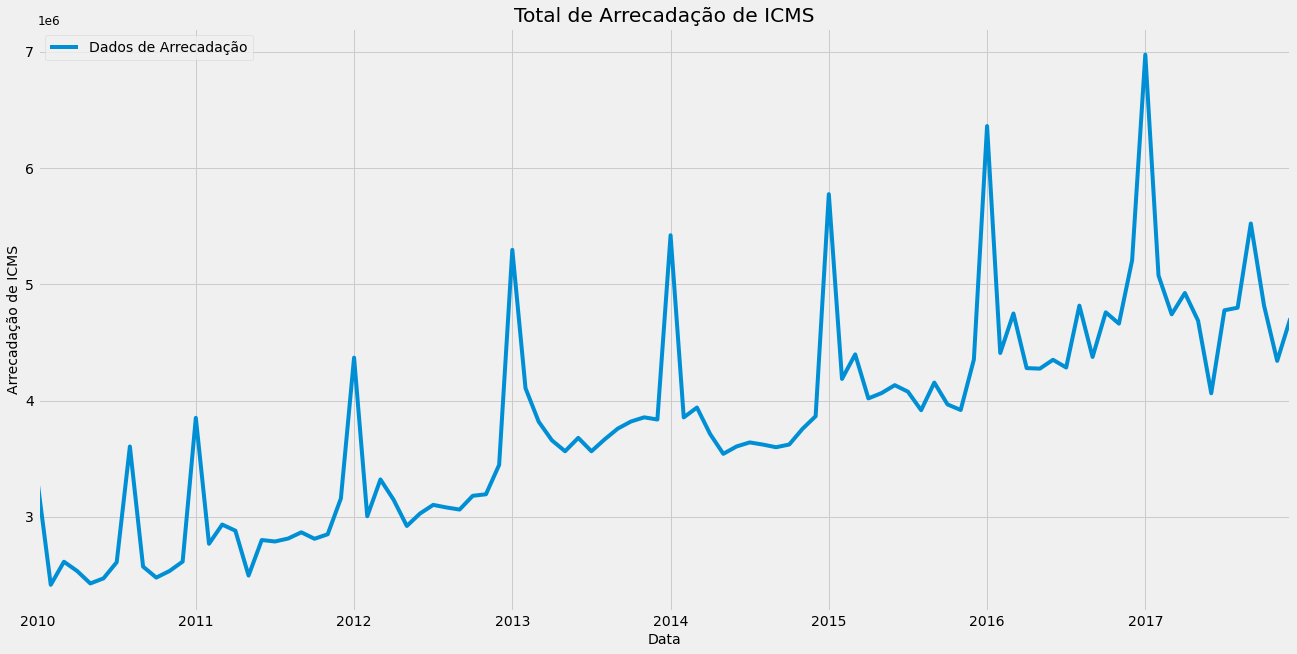

In [9]:
# Plot
target.plot(title = 'Total de Arrecadação de ICMS', fontsize = 14, label = 'Dados de Arrecadação') 
plt.xlabel("Data") 
plt.ylabel("Arrecadação de ICMS") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [10]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

72 24


Para Modelos ARIMA, devemos remover a tendência. Vamos fazer isso.

In [11]:
# Aplicando transformação de log
treino_log = np.log(treino) 

In [12]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
teste_log = np.log(teste)

Vamos testar a estacionaridade da série.

In [13]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

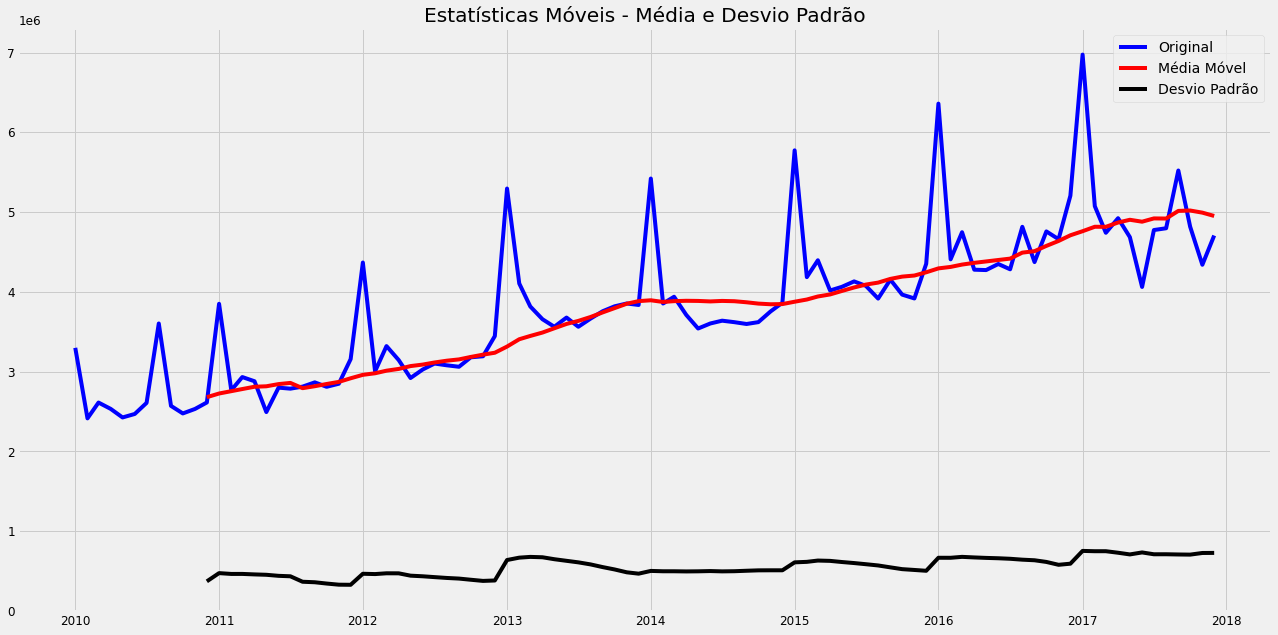


Resultado do Teste Dickey-Fuller:

Estatística do Teste            -3.891400
Valor-p                          0.002099
Número de Lags Consideradas      0.000000
Número de Observações Usadas    95.000000
Valor Crítico (1%)              -3.501137
Valor Crítico (5%)              -2.892480
Valor Crítico (10%)             -2.583275
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [14]:
# Aplica a função 
testa_estacionaridade(dataframe['Arrecadacao'])

O valor-p é menor que 0.05, portanto, não precisamos calcular o valor de 'd'. Ou seja, d = 0 no Modelo ARIMA.

Você rejeitará a hipótese nula e poderá inferir que a série temporal É ESTACIONÁRIA.

## Forecasting - Modelagem Preditiva Para Séries Temporais

### Modelo ARIMA

Vamos criar nosso primeiro Modelo ARIMA. Para começar vamos criar um modelo simples, treiná-los e fazer previsões e nos modelos seguintes vamos explorar os detalhes de Modelos ARIMA, como interpretar o resultado, os resíduos e melhorar o modelo.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

In [15]:
# Cria o Modelo ARIMA

# Definimos:

# p = 2
# d = 1
# q = 0

# Aqui o valor q é zero, pois é apenas o modelo AR. Nas próximas aulas eu explico porque.

# Modelo
modelo_AR = ARIMA(treino_log, order = (2, 1, 0))

C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Você pode estar se perguntando: Mas por que usamos os dados originais aqui? Não deveríamos usar a série diferenciada? 

De forma bem clara e objetiva, a resposta é: Não. 

Realizamos todas essas etapas de diferenciação e outras transformações para descobrir os coeficientes do modelo ARIMA. 

'I' no ARIMA significa Integração, que leva em consideração o número de dados diferenciados necessários para se tornar a série estacionária (ou seja, o Modelo ARIMA faz todo o trabalho). 

Realizamos essas etapas de diferenciação no início para encontra o valor ideal de "I". De fato, você deve comparar modelos diferentes com valores diferentes dessas variáveis para obter o melhor modelo.

O Pré-Processamento que fazemos nas séries temporais é para encontrar os melhores valores de p, d e q que colocamos aqui: order = (2, 1, 0).

Portanto, treinamos o modelo com TODOS os dados, a série inteira (dados de treino). Estudaremos isso nas aulas seguintes. 

In [16]:
# Treinamento
modelo_v1 = modelo_AR.fit(disp = -1)  

Vamos fazer previsões com o modelo.

In [17]:
# Sumário do Modelo - Nas próximas aulas vamos interpretar esse sumário do modelo
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Arrecadacao   No. Observations:                   71
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  39.983
Method:                       css-mle   S.D. of innovations              0.137
Date:                Sat, 22 Aug 2020   AIC                            -71.966
Time:                        19:06:35   BIC                            -62.915
Sample:                    02-01-2010   HQIC                           -68.366
                         - 12-01-2015                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0051      0.010      0.533      0.594      -0.014       0.024
ar.L1.D.Arrecadacao    -0.5230      0.119     -4.379      0.000      -0.757      -0.289
ar.L2.D.Arrecadacao    -0.1994      0.119     -1.682      0.093      -0.432       0.033
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3116           -1.8153j            2.2395           -0.3496
AR.2           -1.3116           +1.8153j            2.2395            0.3496
-----------------------------------------------------------------------------
"""

Agora vamos fazer previsões com o modelo treinado.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html

In [18]:
# Forecast
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
fc, se, conf = modelo_v1.forecast(len(teste_log), alpha = 0.05) 

In [19]:
# Previsões
fc

array([15.24249437, 15.25320278, 15.26510011, 15.26551291, 15.27169527,
       15.2771499 , 15.28183478, 15.28706736, 15.29216695, 15.2972269 ,
       15.30233409, 15.30742448, 15.31251424, 15.31760768, 15.32269932,
       15.32779117, 15.33288326, 15.33797519, 15.34306716, 15.34815913,
       15.3532511 , 15.35834307, 15.36343504, 15.368527  ])

In [20]:
# Erro
se

array([0.1374997 , 0.15234022, 0.17014837, 0.19010366, 0.20550018,
       0.22044154, 0.23458232, 0.24773245, 0.26028419, 0.2722588 ,
       0.28371606, 0.29473435, 0.30535454, 0.31561684, 0.32555633,
       0.33520109, 0.34457597, 0.35370249, 0.36259936, 0.3712831 ,
       0.37976833, 0.38806807, 0.39619399, 0.40415655])

In [21]:
# Coeficientes
conf

array([[14.97299992, 15.51198882],
       [14.95462144, 15.55178411],
       [14.93161543, 15.59858478],
       [14.89291658, 15.63810923],
       [14.86892232, 15.67446822],
       [14.84509242, 15.70920739],
       [14.82206189, 15.74160767],
       [14.80152068, 15.77261404],
       [14.78201932, 15.80231459],
       [14.76360946, 15.83084434],
       [14.74626084, 15.85840735],
       [14.72975578, 15.88509318],
       [14.71403033, 15.91099815],
       [14.69901004, 15.93620532],
       [14.68462064, 15.960778  ],
       [14.6708091 , 15.98477324],
       [14.65752678, 16.00823975],
       [14.64473105, 16.03121933],
       [14.63238547, 16.05374884],
       [14.62045763, 16.07586063],
       [14.60891885, 16.09758335],
       [14.59774362, 16.11894251],
       [14.58690909, 16.13996098],
       [14.57639472, 16.16065929]])

In [22]:
# Precisamos criar um dataframe para criar o Plot
fc_series = pd.Series(fc, index = teste_log.index)
limite_inferior = pd.Series(conf[:, 0], index = teste_log.index)
limite_superior = pd.Series(conf[:, 1], index = teste_log.index)

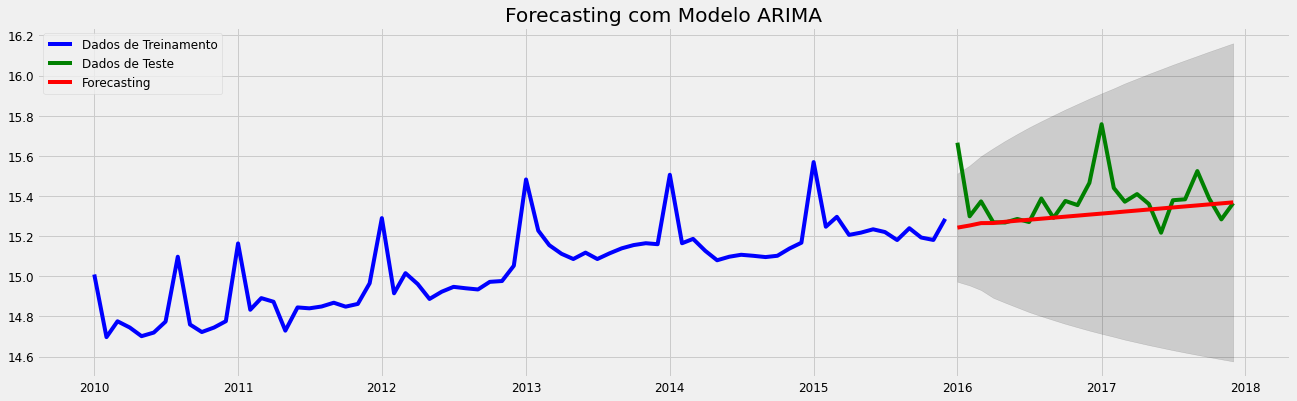

In [23]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(treino_log, label = 'Dados de Treinamento', color = 'blue')
plt.plot(teste_log, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting', color = 'red')
plt.fill_between(limite_inferior.index, limite_inferior, limite_superior, color = 'k', alpha = .15)
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

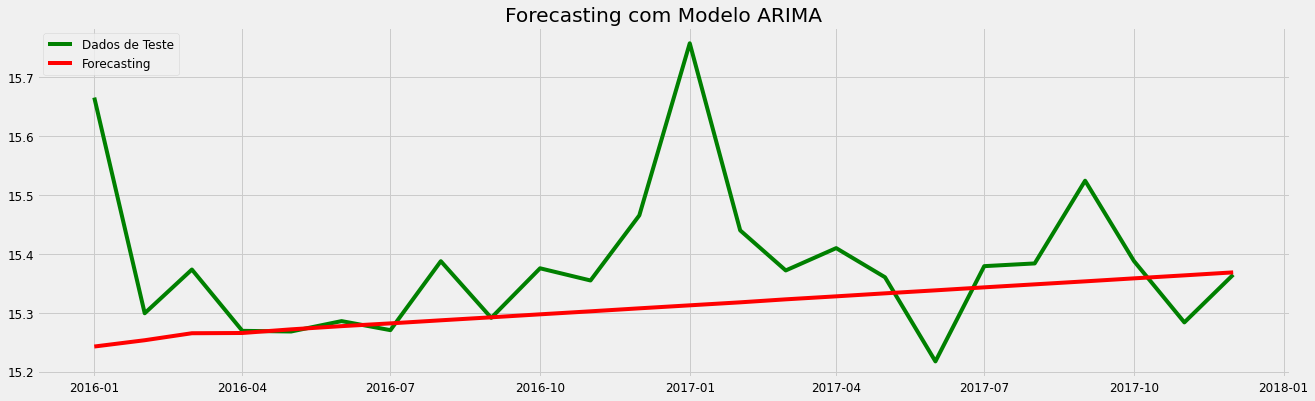

In [24]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste_log, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

Pronto! Temos a previsão da nossa série! Nosso modelo está muito bom e poderia ser usado para resolver nosso problema de negócio.


In [25]:
# Define valor real e valor previsto
y_true = teste_log
y_pred = fc_series

In [26]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.14629830173133296


In [27]:
# Define valor real e valor previsto invertendo o LOG
y_true = np.exp(teste_log)
y_pred = np.exp(fc_series)

In [32]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

767631.9506267529


Não reduzimos o erro do nosso modelo. 

Reduzimos de 805471.0878 (naive) para 750397.7727 (previsoes_v2 modelo 12) e aumentou para 767631.9506 (modelo 13).

Você pode estar estranhando o gráfico, mas o que fizemos foi usar a série com a transformação de log, o que muda a escala dos dados. Porém os dados são os mesmos.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim